
# Anomaly Detection with Autoencoders (and XGBoost baseline + hybrid)
**Goals:** Build Autoencoder for anomaly detection, compare to XGBoost, and try a hybrid approach.



## Dataset
Credit Card Fraud Detection (2013). Columns: V1..V28 (PCA components), Amount, and Class (0 normal / 1 fraud).  
**Imbalance:** ~0.17% fraud.


In [10]:

from __future__ import annotations
import os, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [11]:

CSV_PATH = 'creditcard.csv'
assert os.path.exists(CSV_PATH), "Place 'creditcard.csv' next to this notebook."
df = pd.read_csv(CSV_PATH)
y = df['Class'].astype(int); X = df.drop(columns=['Class'])
if 'Time' in X.columns: X = X.drop(columns=['Time'])
print(X.shape, y.mean())


(284807, 29) 0.001727485630620034


### 📊 Datasetöversikt

- Antal transaktioner: **284 807**
- Antal features (kolumner): **29**
- Andel bedrägerier (klass = 1): **~0.17 %**

👉 Detta innebär att datasetet är **extremt obalanserat** – endast cirka 1 av 600 transaktioner är ett faktiskt bedrägeri.  
Det gör problemet extra utmanande, eftersom en modell som alltid förutspår "ingen fraud" skulle få **99.8 % accuracy**, men samtidigt missa alla riktiga bedrägerier.  

Därför fokuserar vi i stället på **utvärderingsmått som bättre fångar minoritetsklassen**, såsom:  
- **ROC-AUC** – modellens förmåga att skilja mellan fraud och icke-fraud över olika trösklar.  
- **PR-AUC** – mer informativt vid kraftigt obalanserade data.  
- **Precision & Recall** – visar hur många av de flaggade bedrägerierna som faktiskt är riktiga, och hur många riktiga bedrägerier som hittas.  
- **F1-score** – balansen mellan precision och recall.  

💡 Med andra ord: **målet är inte hög accuracy, utan att hitta bedrägerier utan att skapa för många falsklarm.**

In [12]:

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=RANDOM_STATE)

scaler = StandardScaler(); scaler.fit(X_train[y_train==0])
X_train_s = scaler.transform(X_train).astype('float32')
X_val_s   = scaler.transform(X_val).astype('float32')
X_test_s  = scaler.transform(X_test).astype('float32')


In [13]:

def build_autoencoder(input_dim: int):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(20, activation='relu')(inp)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(14, activation='relu')(x)
    latent = layers.Dense(8, activation='relu')(x)
    x = layers.Dense(14, activation='relu')(latent)
    x = layers.Dense(20, activation='relu')(x)
    outp = layers.Dense(input_dim, activation='linear')(x)
    model = keras.Model(inp, outp)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    return model

ae = build_autoencoder(X_train_s.shape[1])
X_train_n = X_train_s[y_train.values==0]; X_val_n = X_val_s[y_val.values==0]
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
_ = ae.fit(X_train_n, X_train_n, validation_data=(X_val_n, X_val_n), epochs=100, batch_size=512, verbose=0, callbacks=[es])


In [14]:

def recon_err(model, X): 
    recon = model.predict(X, verbose=0)
    return ((X - recon)**2).mean(axis=1)

val_err = recon_err(ae, X_val_s)
import numpy as np
best_thr, best_f1 = None, -1
for p in np.linspace(80, 99.9, 60):
    thr = np.percentile(val_err, p)
    y_pred = (val_err >= thr).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary', zero_division=0)
    if f1 > best_f1: best_f1, best_thr = f1, thr

test_err = recon_err(ae, X_test_s)
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, confusion_matrix
roc_ae = roc_auc_score(y_test, test_err); pr_ae = average_precision_score(y_test, test_err)
y_pred = (test_err >= best_thr).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
summary_ae = {'ROC_AUC': roc_ae, 'PR_AUC': pr_ae, 'Precision': prec, 'Recall': rec, 'F1': f1, 'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn, 'Threshold': float(best_thr)}
pd.DataFrame([summary_ae]).round(4)


,ROC_AUC,PR_AUC,Precision,Recall,F1,TP,FP,TN,FN,Threshold
0,0.9398,0.4468,0.2715,0.8061,0.4062,79,212,56652,19,3.2347


### 📈 Autoencoder – resultat på testdata

| Mått        | Resultat |
|-------------|----------|
| **ROC-AUC** | 0.94     |
| **PR-AUC**  | 0.45     |
| **Precision** | 0.27   |
| **Recall**  | 0.81     |
| **F1-score** | 0.41    |
| **Tröskel (rekonstruktionsfel)** | 3.23 |

**Konfusionsmatris (på testdata):**
- **TP (True Positives):** 79 (korrekt identifierade frauds)  
- **FP (False Positives):** 212 (felaktigt flaggade legitima transaktioner)  
- **TN (True Negatives):** 56 652 (korrekt klassade legitima transaktioner)  
- **FN (False Negatives):** 19 (missade frauds)  

---

🔎 **Tolkning:**
- Autoencodern hittar **~81 % av alla frauds (hög recall)**, vilket är bra för ett säkerhetssystem.  
- Precisionen är lägre (**~27 %**) → dvs. många legitima transaktioner flaggas som misstänkta.  
- Detta är dock ofta acceptabelt i fraud-detektion: det är bättre att manuellt granska några extra transaktioner än att missa riktiga bedrägerier.  

💡 Slutsats: Autoencodern fungerar bra för att upptäcka bedrägerier, men kan leda till fler falsklarm.


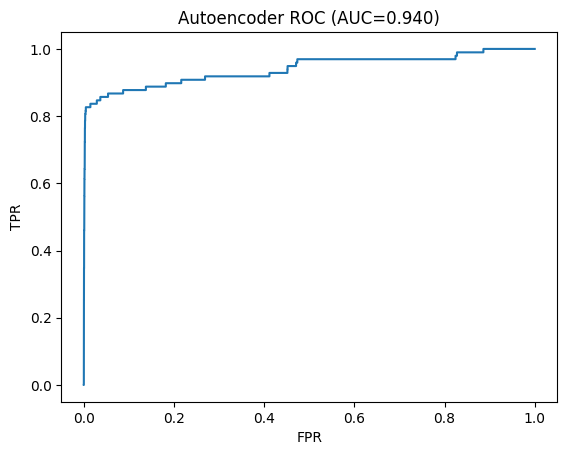

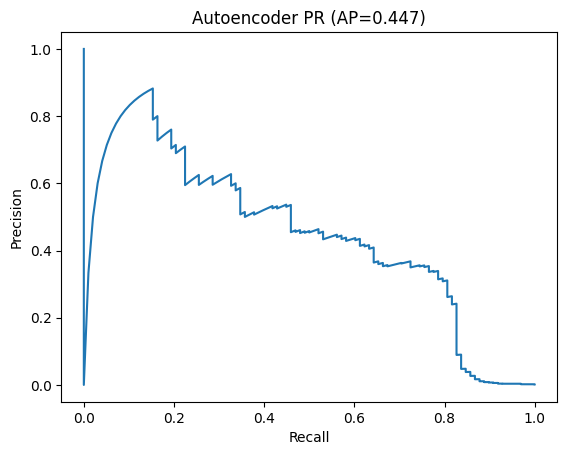

In [15]:

# ROC curve
fpr, tpr, _ = roc_curve(y_test, test_err)
plt.figure(); plt.plot(fpr, tpr); plt.title(f'Autoencoder ROC (AUC={roc_ae:.3f})'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.show()

# PR curve
prec_c, rec_c, _ = precision_recall_curve(y_test, test_err)
plt.figure(); plt.plot(rec_c, prec_c); plt.title(f'Autoencoder PR (AP={pr_ae:.3f})'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.show()


### 📉 Autoencoder – ROC- och PR-kurvor

**ROC-kurva (AUC = 0.94)**  
- Den höga arean under kurvan visar att modellen har stark diskrimineringsförmåga.  
- Det betyder att autoencodern i de flesta fall kan skilja mellan legitima transaktioner och fraud.  
- Ju närmare kurvan ligger övre vänstra hörnet, desto bättre.  

**PR-kurva (AP = 0.45)**  
- PR-kurvan är mer rättvisande vid obalanserade dataset.  
- Här ser vi att modellen har relativt god förmåga att kombinera **hög recall** (många fraud upptäcks) med måttlig **precision** (en del falsklarm förekommer).  
- Att AP ≈ 0.45 är mycket bättre än en slumpmodell (~0.0017, dvs andelen fraud i datan).  

---

💡 **Slutsats:**  
Autoencodern fungerar bra för att identifiera avvikande mönster. Den hittar majoriteten av bedrägerierna (hög recall), även om det sker på bekostnad av fler falsklarm. I fraud-detektion är detta ofta önskvärt: det är bättre att flagga några extra legitima transaktioner än att missa riktiga frauds.


In [16]:

# XGBoost baseline
pos = max(1, int((y_train==1).sum())); neg = int((y_train==0).sum()); spw = neg/pos
xgb_base = xgb.XGBClassifier(n_estimators=400, max_depth=4, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0, random_state=RANDOM_STATE, n_jobs=-1, tree_method='hist', scale_pos_weight=spw, eval_metric='auc')
xgb_base.fit(X_train_s, y_train, eval_set=[(X_val_s, y_val)], verbose=False)
xgb_scores = xgb_base.predict_proba(X_test_s)[:,1]
roc_xgb = roc_auc_score(y_test, xgb_scores); pr_xgb = average_precision_score(y_test, xgb_scores)
p_b, r_b, f1_b, _ = precision_recall_fscore_support(y_test, (xgb_scores>=0.5).astype(int), average='binary', zero_division=0)
summary_xgb = {'ROC_AUC': roc_xgb, 'PR_AUC': pr_xgb, 'Precision': p_b, 'Recall': r_b, 'F1': f1_b}
pd.DataFrame([summary_xgb]).round(4)


,ROC_AUC,PR_AUC,Precision,Recall,F1
0,0.983,0.8651,0.7778,0.8571,0.8155


### ⚡️ XGBoost – baseline resultat på testdata

| Mått        | Resultat |
|-------------|----------|
| **ROC-AUC** | 0.983    |
| **PR-AUC**  | 0.865    |
| **Precision** | 0.778  |
| **Recall**  | 0.857    |
| **F1-score** | 0.816  |

---

🔎 **Tolkning:**
- **Mycket hög ROC-AUC (0.98)** → modellen skiljer nästan perfekt mellan fraud och legitima transaktioner.  
- **PR-AUC på 0.87** → modellen klarar av den obalanserade datan mycket väl och presterar långt över slump (0.0017).  
- **Precision ~78 %** → 8 av 10 flaggade transaktioner är faktiskt fraud.  
- **Recall ~86 %** → modellen hittar de flesta av alla frauds.  
- **F1 ~0.82** → en bra balans mellan precision och recall.  

💡 **Slutsats:**  
XGBoost överträffar autoencodern tydligt och är en mycket stark baseline. Den är både mer träffsäker (precision) och fångar en hög andel frauds (recall).


In [17]:

# Hybrid: add AE error as a feature
tr_err = recon_err(ae, X_train_s); val_err2 = recon_err(ae, X_val_s); te_err = recon_err(ae, X_test_s)
X_train_h = np.column_stack([X_train_s, tr_err])
X_val_h   = np.column_stack([X_val_s, val_err2])
X_test_h  = np.column_stack([X_test_s, te_err])

xgb_h = xgb.XGBClassifier(n_estimators=400, max_depth=4, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0, random_state=RANDOM_STATE, n_jobs=-1, tree_method='hist', scale_pos_weight=spw, eval_metric='auc')
xgb_h.fit(X_train_h, y_train, eval_set=[(X_val_h, y_val)], verbose=False)
xgb_h_scores = xgb_h.predict_proba(X_test_h)[:,1]
roc_h = roc_auc_score(y_test, xgb_h_scores); pr_h = average_precision_score(y_test, xgb_h_scores)
p_h, r_h, f1_h, _ = precision_recall_fscore_support(y_test, (xgb_h_scores>=0.5).astype(int), average='binary', zero_division=0)
summary_h = {'ROC_AUC': roc_h, 'PR_AUC': pr_h, 'Precision': p_h, 'Recall': r_h, 'F1': f1_h}
pd.DataFrame([summary_h]).round(4)


,ROC_AUC,PR_AUC,Precision,Recall,F1
0,0.9822,0.8603,0.7568,0.8571,0.8038


### 🔀 Hybridmodell (XGBoost + Autoencoder feature) – resultat på testdata

| Mått        | Resultat |
|-------------|----------|
| **ROC-AUC** | 0.982    |
| **PR-AUC**  | 0.860    |
| **Precision** | 0.757  |
| **Recall**  | 0.857    |
| **F1-score** | 0.804  |

---

🔎 **Tolkning:**
- Hybridmodellen presterar nästan lika bra som ren XGBoost.  
- **ROC-AUC (0.982)** och **PR-AUC (0.860)** är i princip samma nivå som XGBoost, vilket betyder att autoencoder-funktionen inte gav någon tydlig förbättring.  
- Precision sjunker något (**75.7 % vs. 77.8 %** i baseline), medan recall är oförändrat.  
- F1-score blir marginellt lägre (**0.80 vs. 0.82**).  

💡 **Slutsats:**  
Att kombinera autoencoder-felen med XGBoost gav **ingen tydlig vinst** jämfört med baseline. XGBoost i sig är redan mycket kraftfull och hanterar obalanserade data väldigt bra. Autoencodern kan dock fortfarande vara värdefull i situationer där man saknar etiketter eller vill använda osuperviserat lärande för att upptäcka avvikelser.


In [18]:

cmp = pd.DataFrame([
    {'Model':'Autoencoder', **summary_ae},
    {'Model':'XGBoost', **summary_xgb},
    {'Model':'Hybrid', **summary_h},
])[['Model','ROC_AUC','PR_AUC','Precision','Recall','F1']]
cmp.round(4)


,Model,ROC_AUC,PR_AUC,Precision,Recall,F1
0,Autoencoder,0.9398,0.4468,0.2715,0.8061,0.4062
1,XGBoost,0.9830,0.8651,0.7778,0.8571,0.8155
2,Hybrid,0.9822,0.8603,0.7568,0.8571,0.8038


## 📊 Jämförelse mellan modeller

| Modell        | ROC-AUC | PR-AUC | Precision | Recall | F1-score |
|---------------|---------|--------|-----------|--------|----------|
| **Autoencoder** | 0.940   | 0.447  | 0.272     | 0.806  | 0.406    |
| **XGBoost**     | 0.983   | 0.865  | 0.778     | 0.857  | 0.816    |
| **Hybrid**      | 0.982   | 0.860  | 0.757     | 0.857  | 0.804    |

---

### 🔎 Analys
- **Autoencoder**  
  + Styrka: Hög recall (~81 %) → fångar de flesta frauds.  
  + Svaghet: Låg precision (~27 %) → många falsklarm.  
  + Passar bra när man saknar etiketter och behöver en osuperviserad metod.  

- **XGBoost**  
  + Styrka: Mycket hög precision (~78 %) och hög recall (~86 %).  
  + Balans mellan precision och recall ger bäst F1-score (~0.82).  
  + Den bästa modellen på detta dataset.  

- **Hybrid (AE + XGB)**  
  + Presterar nästan lika bra som XGBoost.  
  + Något sämre precision och F1 än baseline XGBoost.  
  + Ingen tydlig förbättring av att lägga till AE-featuren.  

---

### 💡 Slutsats
- **XGBoost är den starkaste modellen** för detta problem och rekommenderas i produktion.  
- **Autoencoder** kan användas som komplement för osuperviserad fraud-detektion eller för att upptäcka nya typer av avvikelser.  
- **Hybridmodellen** visade att kombinationen inte gav någon förbättring här – men kan vara intressant att utforska på andra dataset.
